# Spinal cord gray matter imaging challenge

In [1]:
from nilearn import plotting
from nilearn.plotting import plot_roi

import sys, os, shutil, subprocess
import numpy as np
import pandas as pd
import nibabel as nib

## Pre-process image 1 and image 2

Register the second image (re-scan) to the first image (initial scan).

In [2]:
os.chdir('../data')

# Register image 2 to image 1
register = subprocess.Popen(
    ["sct_register_multimodal", "-i", "gre-me_e2.nii.gz", "-d", "gre-me.nii.gz", "-param", "step=1,type=im,algo=rigid", "-x", "nn", "-o",
        "gre-me_e2_reg.nii.gz"], stdin=None, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
register.wait()

0

Automatic segmentation of the spinal cord for image 1 and image 2.

In [3]:
# Segment spinal cord
seg_sc_v1 = subprocess.Popen(["sct_deepseg_sc", "-i", "gre-me.nii.gz", "-c", "t2s", "-qc", "./qc"], stdin=None, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
seg_sc_v1.wait()
seg_sc_v2 = subprocess.Popen(["sct_deepseg_sc", "-i", "gre-me_e2_reg.nii.gz", "-c", "t2s", "-qc", "./qc"], stdin=None, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
seg_sc_v2.wait()

0

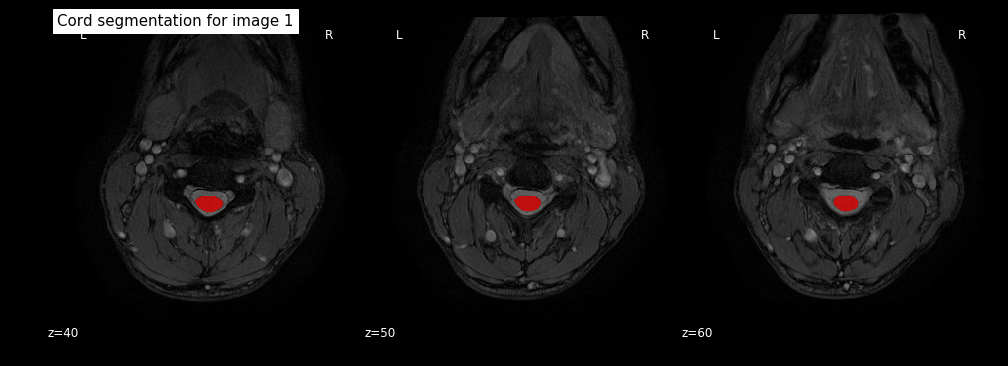

In [4]:
plot_roi("gre-me_seg.nii.gz", "gre-me.nii.gz", display_mode='z', cut_coords=(40,50,60), draw_cross=False, axes=(0,0,2,2), title="Cord segmentation for image 1", cmap=plotting.cm.bwr_r)

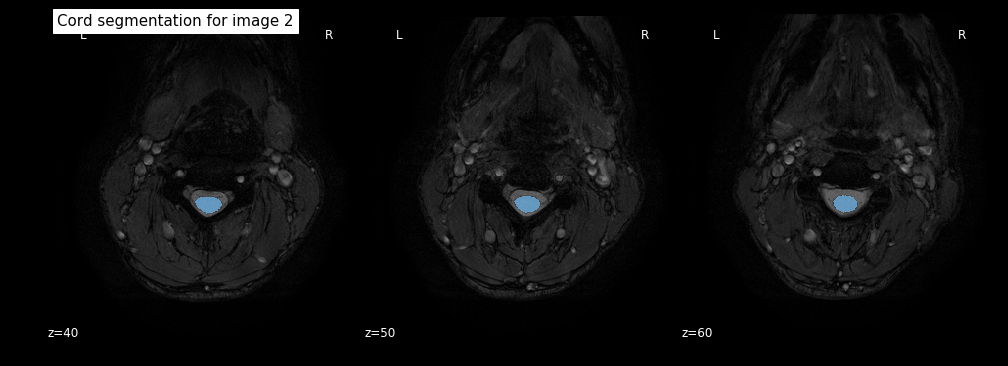

In [5]:
plot_roi("gre-me_e2_reg_seg.nii.gz", "gre-me_e2_reg.nii.gz", display_mode='z', cut_coords=(40,50,60), draw_cross=False, axes=(0,0,2,2), title="Cord segmentation for image 2", cmap=plotting.cm.cyan_copper)

Automatic segmentation of the gray matter for image 1 and image 2.

In [6]:
# Segment gray matter
seg_gm_v1 = subprocess.Popen(["sct_deepseg_gm", "-i", "gre-me.nii.gz"], stdin=None, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
seg_gm_v1.wait()
seg_gm_v2 = subprocess.Popen(["sct_deepseg_gm", "-i", "gre-me_e2_reg.nii.gz"], stdin=None, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
seg_gm_v2.wait()

0

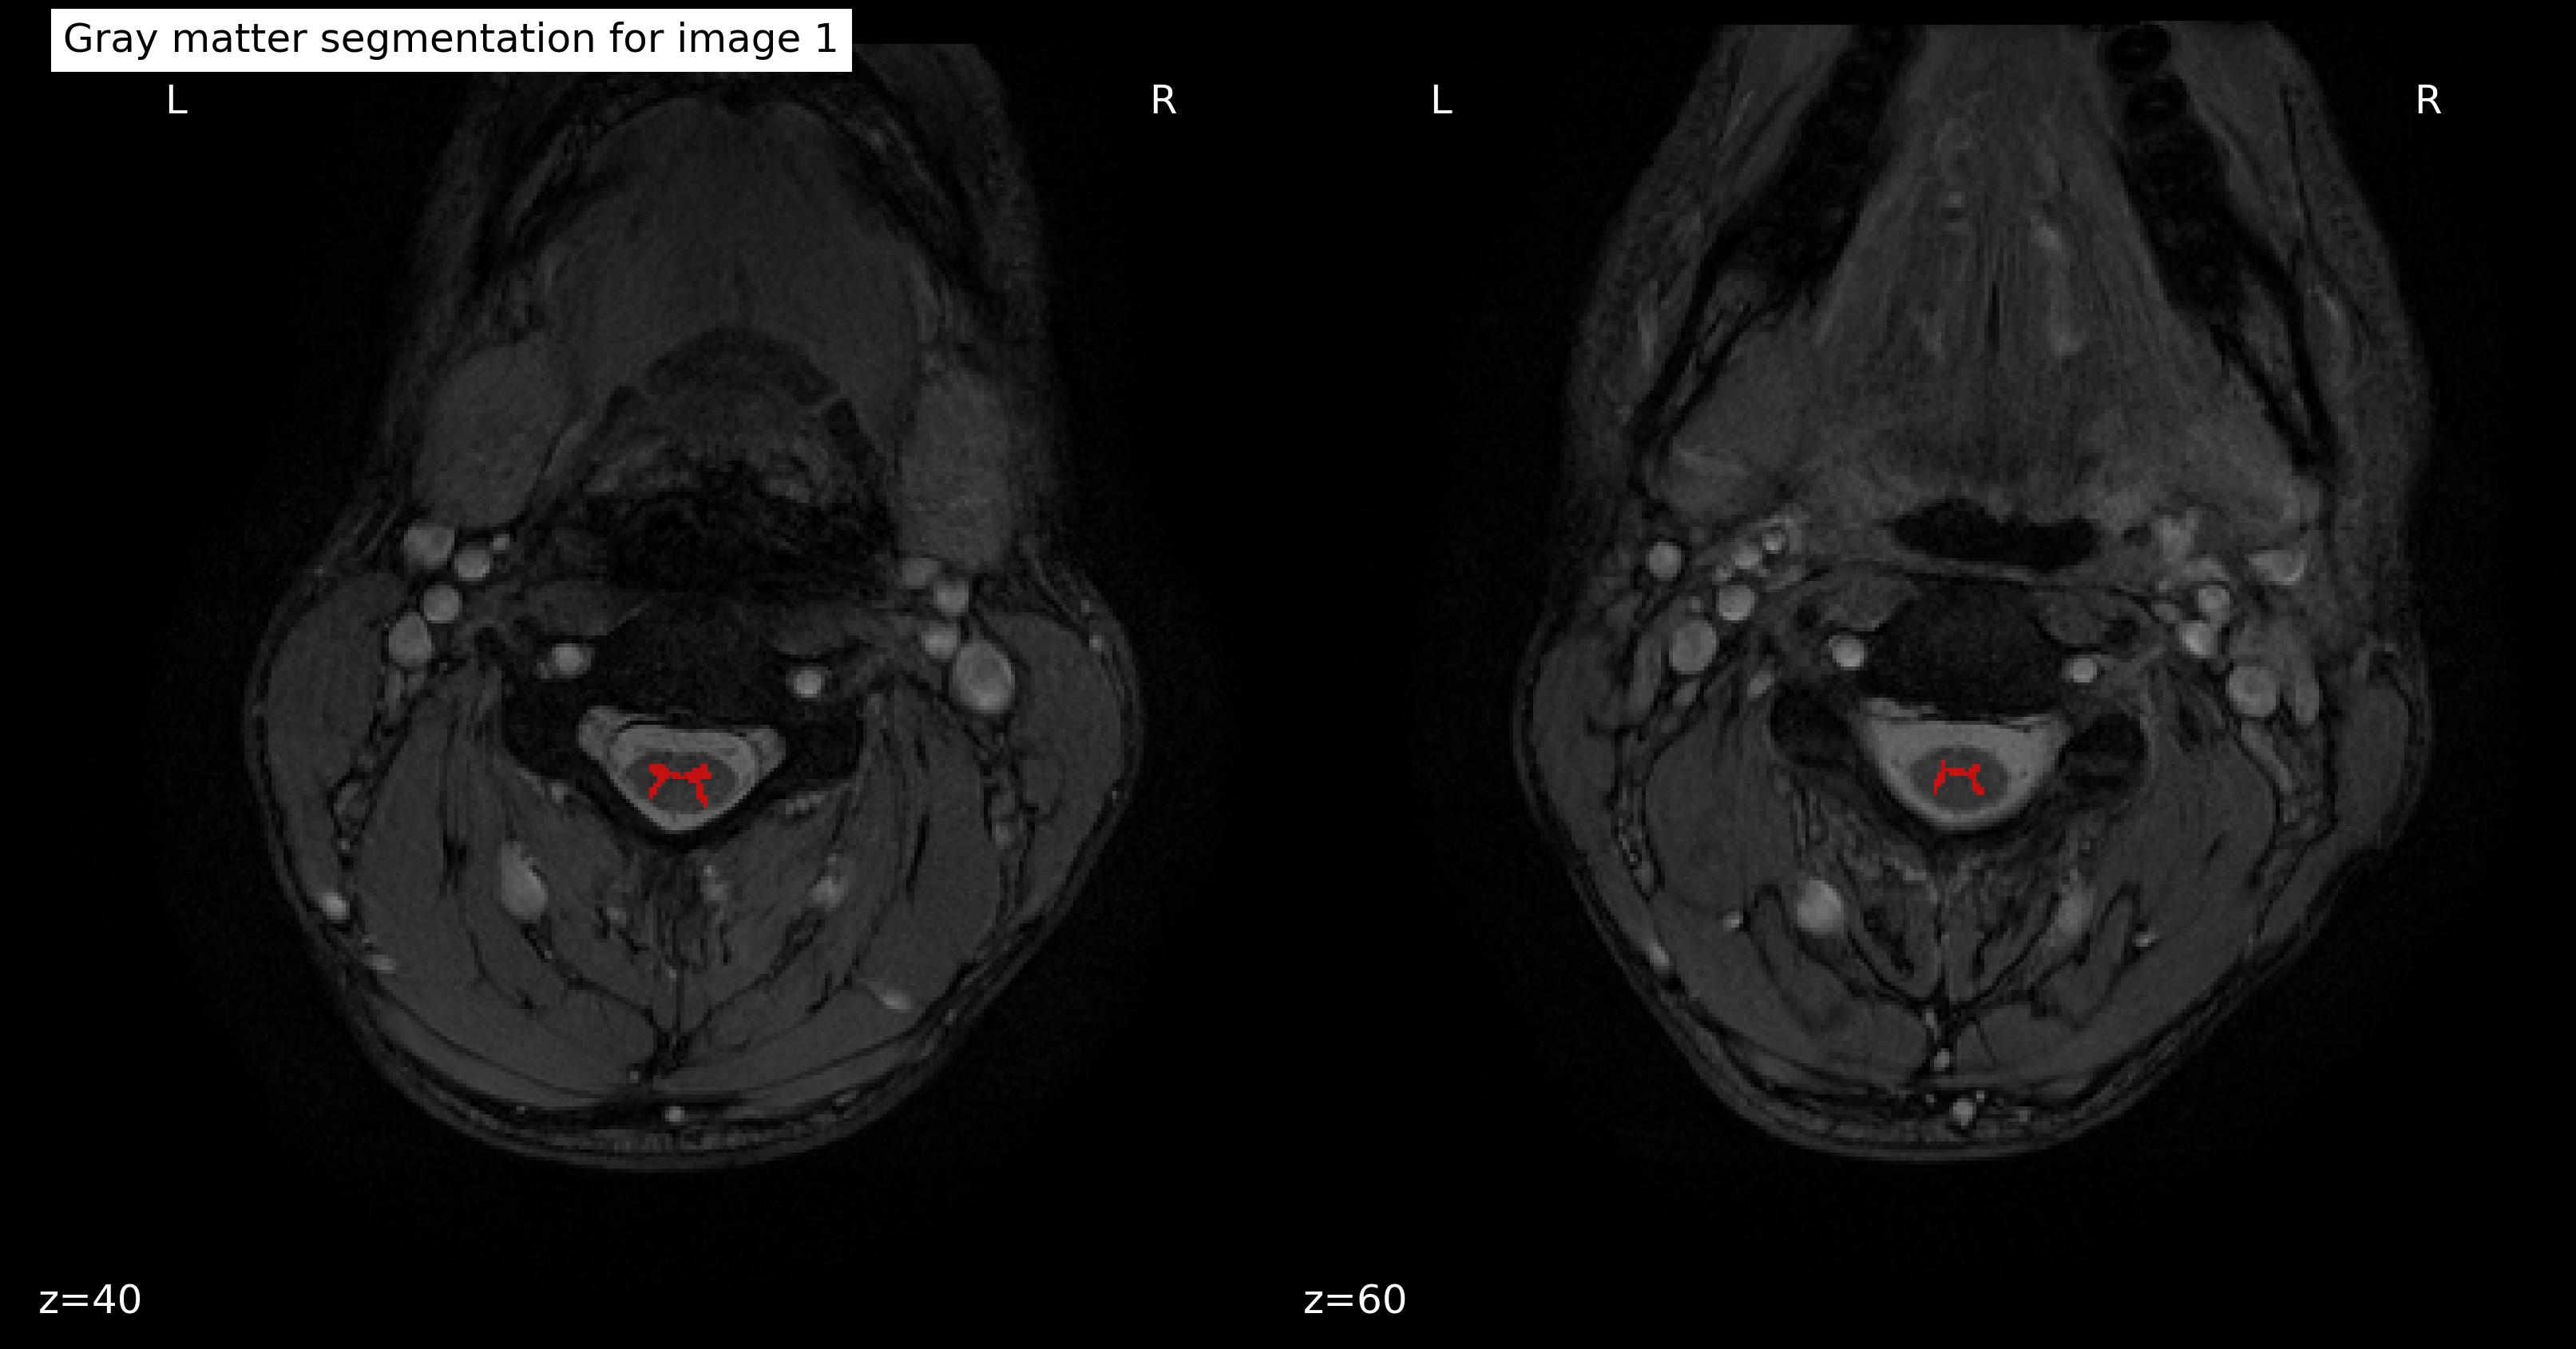

In [7]:
gmseg1=plot_roi("gre-me_gmseg.nii.gz", "gre-me.nii.gz", display_mode='z', cut_coords=(40,60), draw_cross=False, axes=(0,0,10,10), annotate=False, title=False, cmap=plotting.cm.bwr_r)
gmseg1.annotate(size=50)
gmseg1.title("Gray matter segmentation for image 1", size=50)

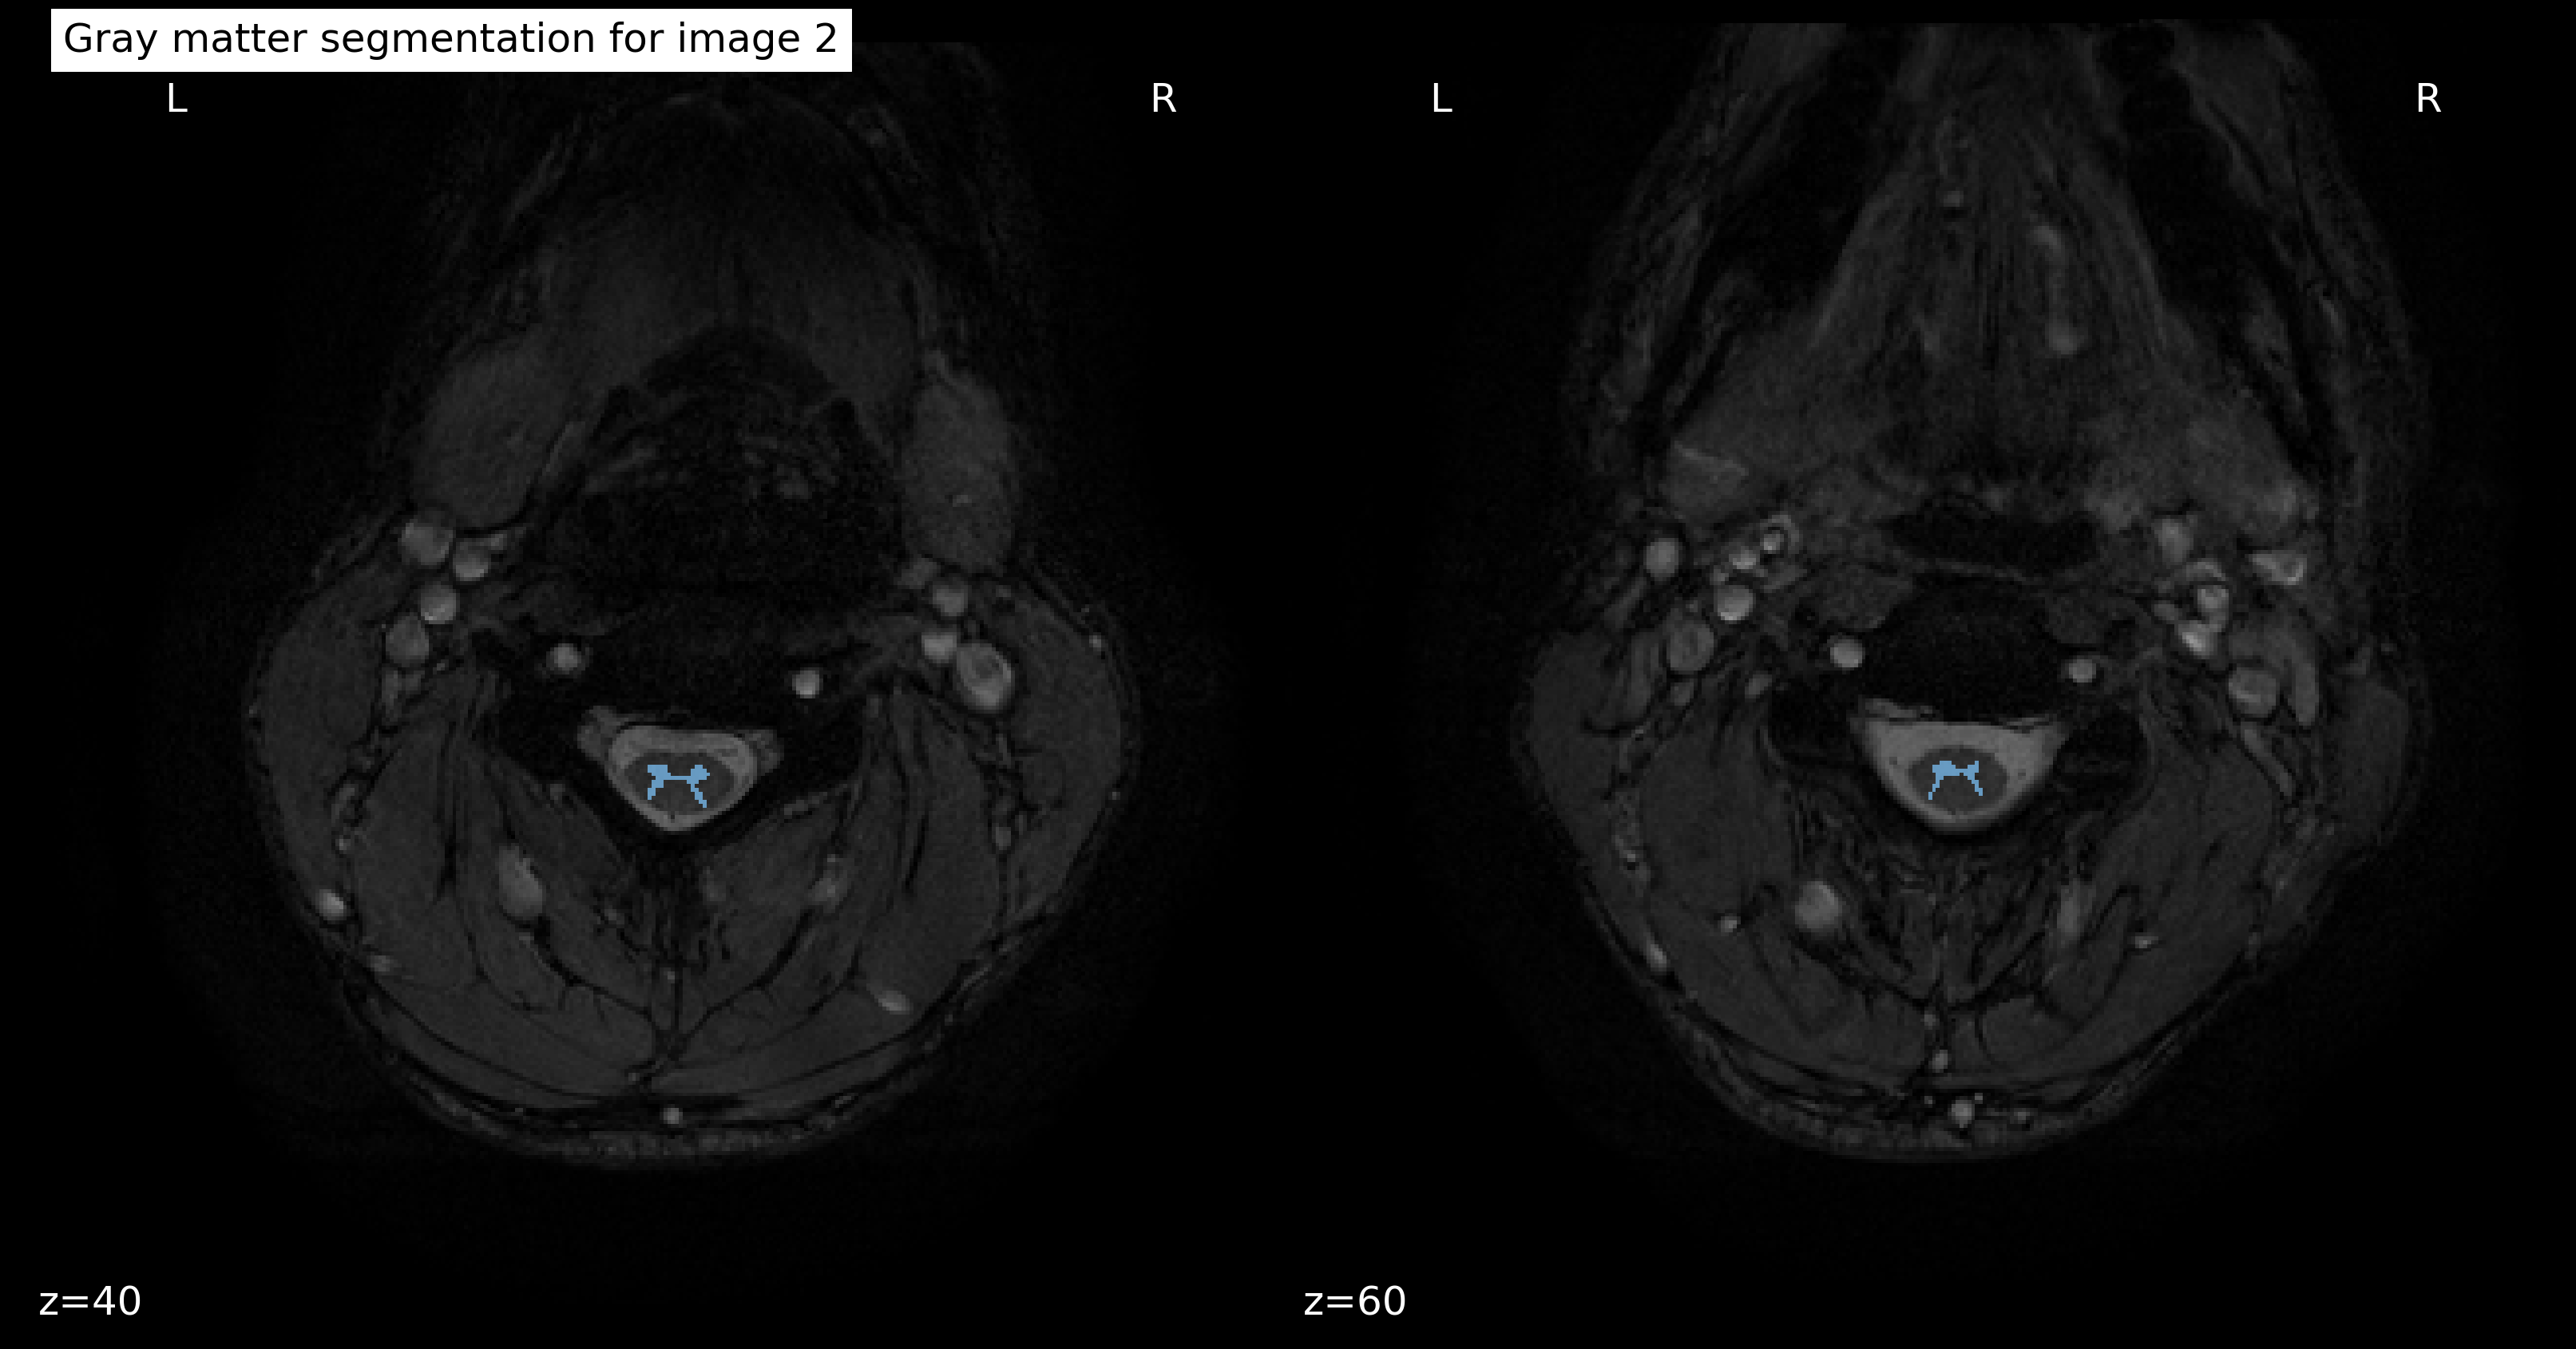

In [8]:
gmseg2=plot_roi("gre-me_e2_reg_gmseg.nii.gz", "gre-me_e2_reg.nii.gz", display_mode='z', cut_coords=(40,60), draw_cross=False, axes=(200,200,10,10), annotate=False, title=False, cmap=plotting.cm.cyan_copper)
gmseg2.annotate(size=50)
gmseg2.title("Gray matter segmentation for image 2", size=50)

Generate white matter segmentation of image 1 and image 2 by subtracting the gray matter segmentation from the cord segmentation.

In [9]:
# Generate white matter segmentation
seg_wm_v1 = subprocess.Popen(["sct_maths", "-i", "gre-me_seg.nii.gz", "-sub", 
                              "gre-me_gmseg.nii.gz", "-o", 
                              "gre-me_wmseg.nii.gz"], stdin=None, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
seg_wm_v1.wait()
seg_wm_v2 = subprocess.Popen(["sct_maths", "-i", "gre-me_e2_reg_seg.nii.gz", "-sub", 
                              "gre-me_e2_reg_gmseg.nii.gz", "-o", 
                              "gre-me_e2_reg_wmseg.nii.gz"], stdin=None, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
seg_wm_v2.wait()

0

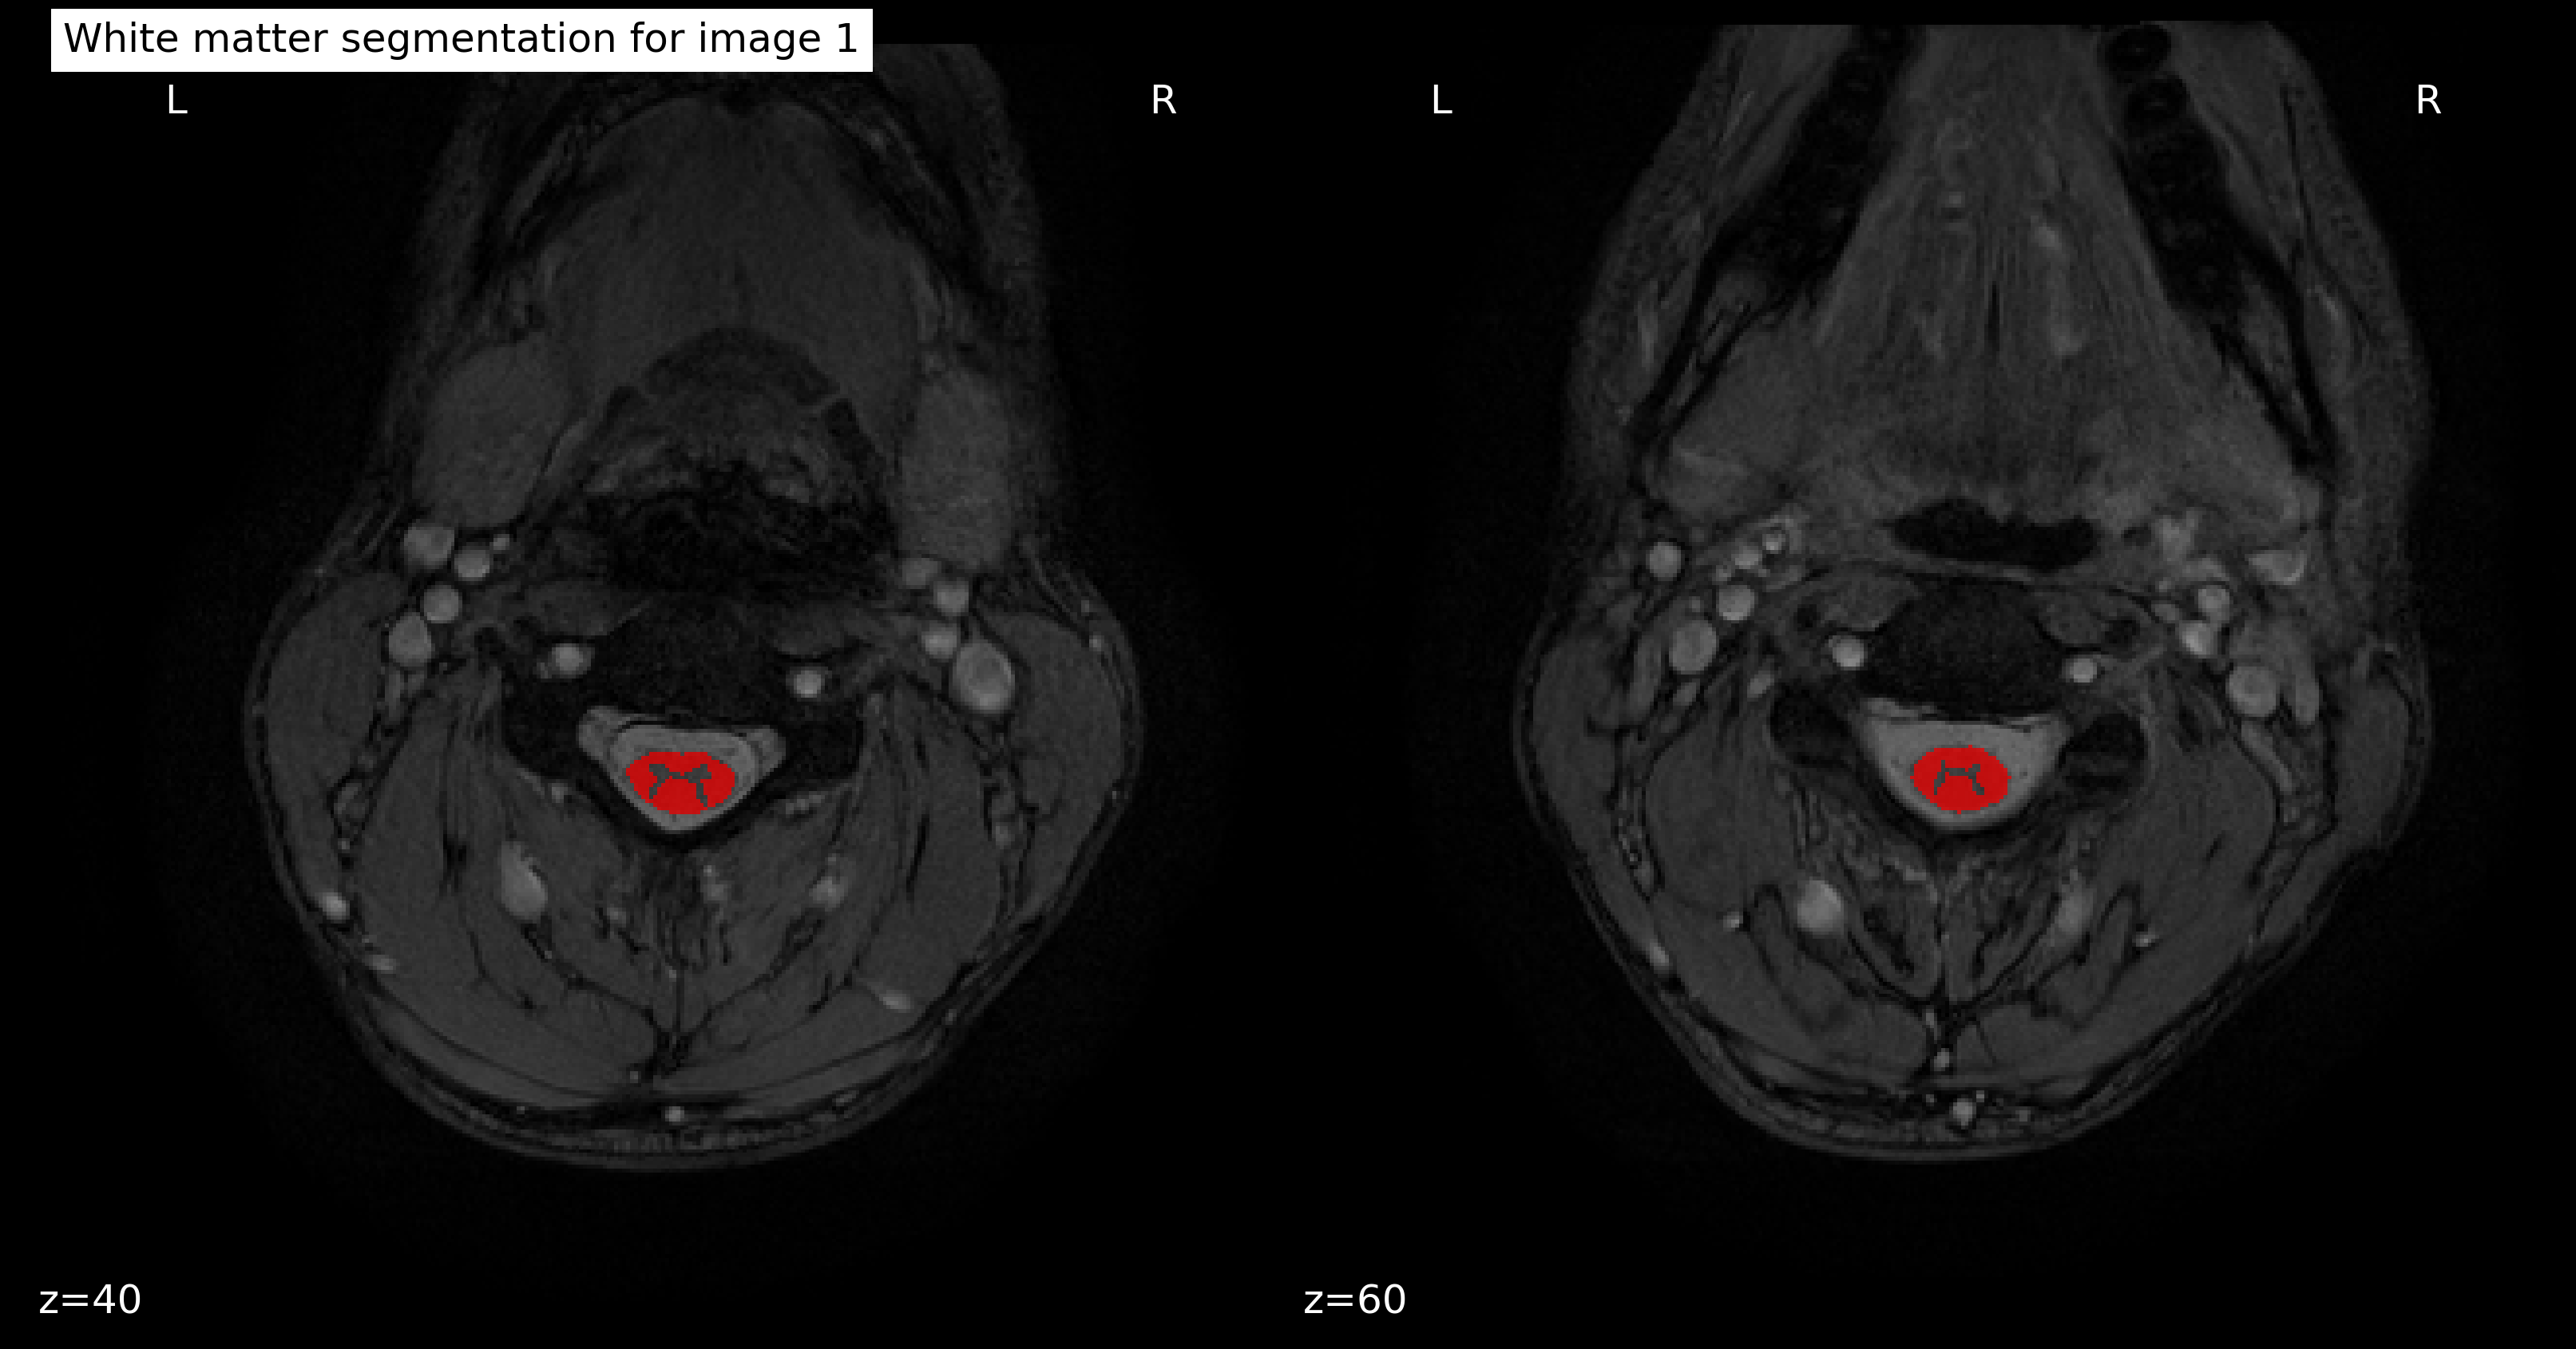

In [10]:
wmseg1=plot_roi("gre-me_wmseg.nii.gz", "gre-me.nii.gz", display_mode='z', cut_coords=(40,60), draw_cross=False, axes=(0,0,10,10), annotate=False, title=False, cmap=plotting.cm.bwr_r)
wmseg1.annotate(size=50)
wmseg1.title("White matter segmentation for image 1", size=50)

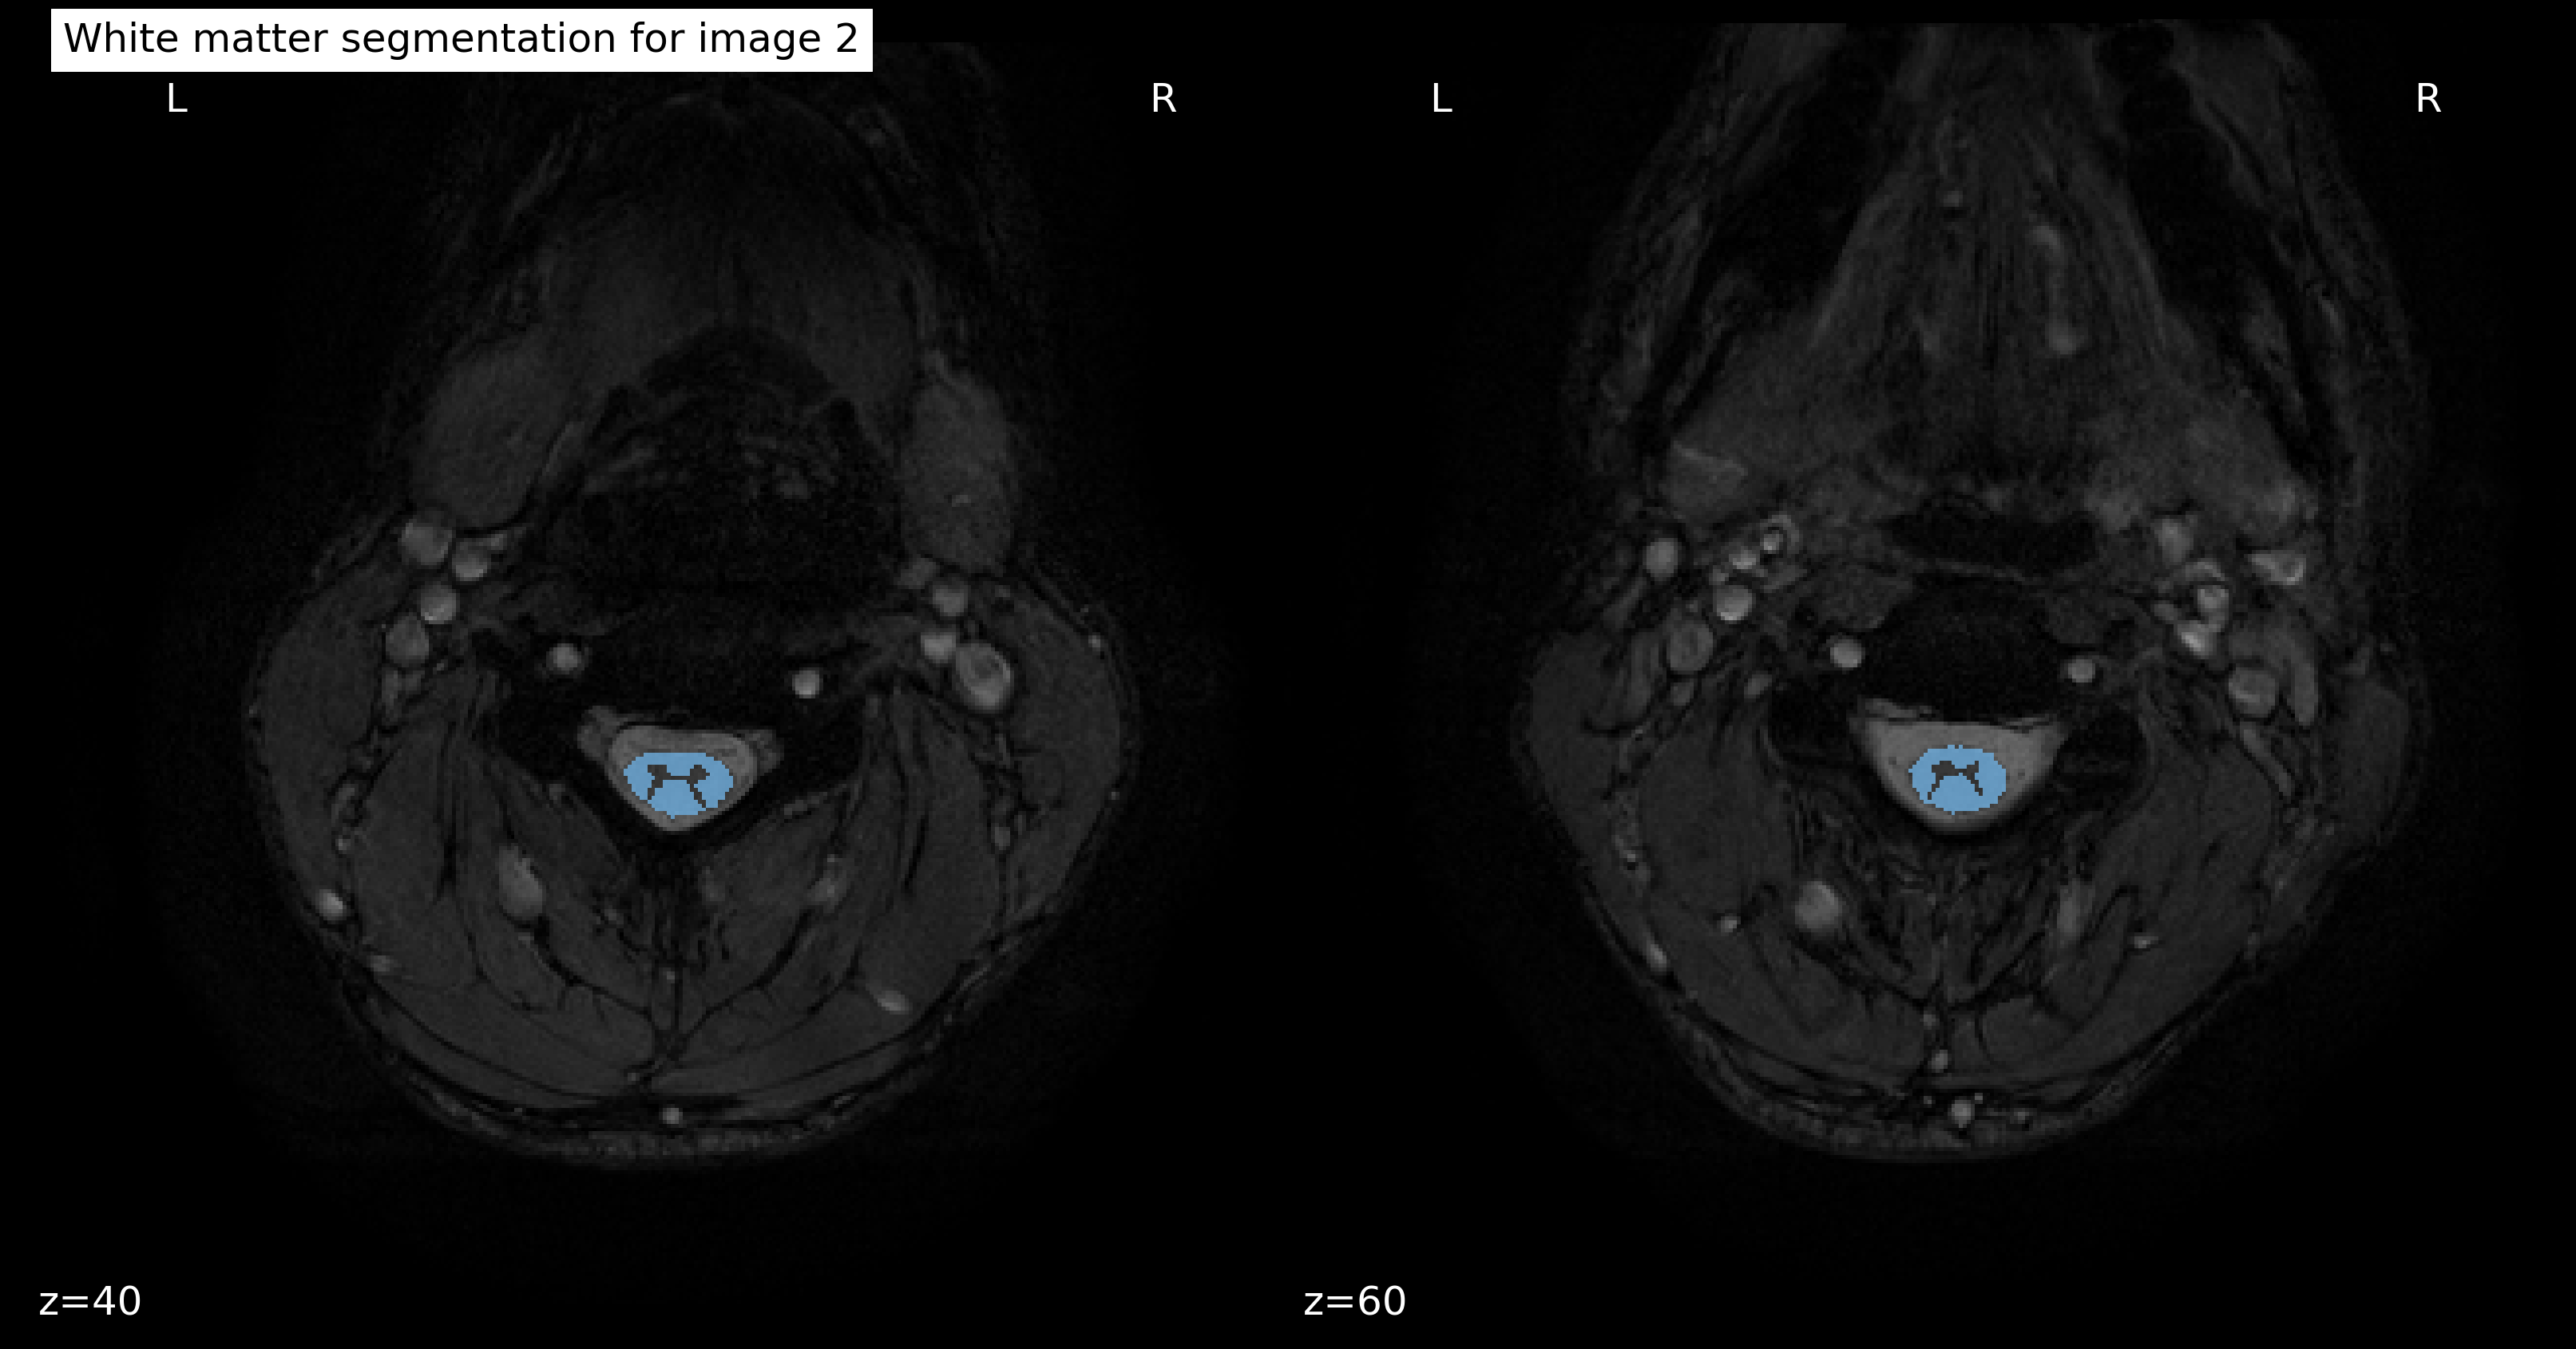

In [11]:
wmseg2=plot_roi("gre-me_e2_reg_wmseg.nii.gz", "gre-me_e2_reg.nii.gz", display_mode='z', cut_coords=(40,60), draw_cross=False, axes=(0,0,10,10), annotate=False, title=False, cmap=plotting.cm.cyan_copper)
wmseg2.annotate(size=50)
wmseg2.title("White matter segmentation for image 2", size=50)

## Analysis: compute metrics

### Signal-to-noise ratio (SNR)

Concatenate image 1 and image 2 to generate the proper input to sct_compute_snr.

In [12]:
concat = subprocess.Popen(
        ["sct_image", "-i", "gre-me.nii.gz,gre-me_e2_reg.nii.gz", "-concat", "t",
         "-o", "t2s_concat.nii.gz"], stdin=None, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
concat.wait()

0

Calculate the SNR.

In [13]:
snr = subprocess.Popen(
        ["sct_compute_snr", "-i", "t2s_concat.nii.gz", "-m", "gre-me_seg.nii.gz", "-vol",
         "0,1"], stdin=None, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
snr_output = snr.communicate()[0]
snr_results = snr_output.split("SNR_diff =")
print "SNR = ",snr_results[1].strip()

SNR =  11.8533889613


### Contrast

Compute the mean signal value in both the white matter and gray matter of image 1.

In [14]:
mean_wm = subprocess.Popen(["sct_extract_metric", "-i", "gre-me.nii.gz", "-f",
                             "gre-me_wmseg.nii.gz", "-method", "max", "-o", "mean_wm.txt"], stdin=None, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
mean_wm.wait()
mean_gm = subprocess.Popen(["sct_extract_metric", "-i", "gre-me.nii.gz", "-f",
                             "gre-me_gmseg.nii.gz", "-method", "max", "-o", "mean_gm.txt"], stdin=None, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
mean_gm.wait()

0

Extract the mean signal value for the white matter and the gray matter. Calculate the contrast value.

In [15]:
with open("mean_wm.txt") as file:
        output_wm = file.readlines()

mean_wm_results = output_wm[-1].split(",")

with open("mean_gm.txt") as file:
        output_gm = file.readlines()

mean_gm_results = output_gm[-1].split(",")
    
contrast = abs(float(mean_wm_results[3]) - float(mean_gm_results[3])) / min([float(mean_wm_results[3]), float(mean_gm_results[3])])
print "Contrast = ",contrast

Contrast =  0.135849996617


### Sharpness

Compute the Laplacian of image 1.

In [16]:
laplacian = subprocess.Popen(["sct_maths", "-i", "gre-me.nii.gz", "-laplacian", "3", "-o",
                             "gre-me_lap.nii.gz"], stdin=None, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
laplacian.wait()

0

Compute the mean Laplacian of the spinal cord for image 1.

In [17]:
mean_lap = subprocess.Popen(["sct_extract_metric", "-i", "gre-me_lap.nii.gz", "-f",
                             "gre-me_seg.nii.gz", "-method", "max", "-o", "sharpness.txt"], stdin=None, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
mean_lap.wait()

0

Extract the mean Laplacian value of the cord.

In [18]:
with open("sharpness.txt") as file:
        output_sharp = file.readlines()

sharpness = output_sharp[-1].split(",")
print "Sharpness =",sharpness[3]

Sharpness =  13.064802
